# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [4]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

In [5]:
# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [6]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [8]:
pretty_categories = ['Atheism', 'Graphics', 'Space', 'Religion']

def P1(num_examples=5):

### STUDENT START ###
    
    for i in xrange(num_examples):
        print ' ---> Example #{}\n\n  - {} -'.format(i+1, pretty_categories[train_labels[i]])
        print '   ', '='*len(pretty_categories[train_labels[i]])
        print train_data[i], '\n'
    
### STUDENT END ###

P1()

 ---> Example #1

  - Graphics -
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

 ---> Example #2

  - Religion -


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for cent

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [5]:
def print_section(label, title):
    print '\n{}) {}'.format(label, title)
    print '  ', '=' * len(title)


def P2():

### STUDENT START ###

    # a) Standard CountVectorizer
    print_section('a', 'Standard CountVectorizer')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    print 'Size of vocabulary:', len(vectorizer.vocabulary_) # also X.shape[1]
    print 'Average number of non-zero features per example: {:.3f}'.format( X.getnnz(axis=1).mean() )
    print 'Fraction of nonzero entries in whole matrix: {:.4%}'.format( 1. * X.nnz / reduce(lambda x,y: x*y, X.shape) )


    # b) Vocabulary
    print_section('b', 'Standard CountVectorizer - Vocabulary')
    print 'First word:', vectorizer.get_feature_names()[0]
    print 'Last word:', vectorizer.get_feature_names()[-1]


    # c) 4 word vocabulary
    print_section('c', '4 Word Vocabulary')
    vect_4vocab = CountVectorizer()
    vect_4vocab.vocabulary = ["atheism", "graphics", "space", "religion"]
    X_4vocab = vect_4vocab.transform(train_data)
    print 'Average number of non-zero features per example: {:.3f}'.format( X_4vocab.getnnz(axis=1).mean() )


    # d) Bigrams and trigrams
    print_section('d', 'Bigrams and Trigrams')
    vect_bigrams = CountVectorizer(analyzer='char', ngram_range=(2,2))
    X_bigrams = vect_bigrams.fit_transform(train_data)
    print 'Bigram vocabulary size:', len(vect_bigrams.vocabulary_)

    vect_trigrams = CountVectorizer(analyzer='char', ngram_range=(3,3))
    X_trigrams = vect_trigrams.fit_transform(train_data)
    print 'Trigram vocabulary size:', len(vect_trigrams.vocabulary_)


    # e) Words in at least 10 documents
    print_section('e', 'Words in at least 10 documents')
    vectorizer_min10 = CountVectorizer(min_df = 10)
    vectorizer_min10.fit_transform(train_data)
    print 'Pruned vocabulary to a min of 10 doc occurrences:', len(vectorizer_min10.vocabulary_)


    # f) Untrained words in dev
    print_section('f', 'Words in dev not in trained vocabulary')
    vectorizer = CountVectorizer()
    X_dev = vectorizer.fit_transform(dev_data)
    vocab_dev = set(vectorizer.vocabulary_.keys())

    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    vocab_train = set(vectorizer.vocabulary_.keys())

    diff_words = len(vocab_dev.difference(vocab_train))
    print 'Words in dev not in train: {} ({:.2%})'.format(diff_words, 1. * diff_words / len(vocab_dev))

### STUDENT END ###

P2()


a) Standard CountVectorizer
Size of vocabulary: 26879
Average number of non-zero features per example: 96.706
Fraction of nonzero entries in whole matrix: 0.3598%

b) Standard CountVectorizer - Vocabulary
First word: 00
Last word: zyxel

c) 4 Word Vocabulary
Average number of non-zero features per example: 0.268

d) Bigrams and Trigrams
Bigram vocabulary size: 3291
Trigram vocabulary size: 32187

e) Words in at least 10 documents
Pruned vocabulary to a min of 10 doc occurrences: 3064

f) Words in dev not in trained vocabulary
Words in dev not in train: 4027 (24.79%)


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [6]:
def pre_P3():
    ''' Use GridSearchCV to find the best parameters for the models '''
    # Vectorize first
    vectorizer = CountVectorizer()
    X_data = vectorizer.fit_transform(train_data)

    # a) KNN model
    print_section('a', 'K Nearest Neighbors model')  # using print_section from P2
    neighbors = {'n_neighbors': [1, 2, 5, 10, 20, 50, 100, 125, 150, 175, 200, 300]}
    knn = KNeighborsClassifier() # initialize estimator
    gridKNN = GridSearchCV(knn, neighbors)
    gridKNN.fit(X_data, train_labels)

    print '  K     AVG-Score    SCORES'
    for row in gridKNN.grid_scores_:
        print "{0[n_neighbors]:>3}     {1:5.1%}     [ {2[0]:5.1%}, {2[1]:5.1%}, {2[2]:5.1%} ]".format(*row)
    print '\n==> Best parameters: {}\n'.format(gridKNN.best_params_)


    # b) MNB model
    print_section('b', 'Multinomial NaiveBayes model')
    alphas = {'alpha': [0.0001, 0.001, .005, .01, .02, 0.5, 1, 2, 5, 10]}
    mnb = MultinomialNB(fit_prior=False)
    gridMNB = GridSearchCV(mnb, alphas)
    gridMNB.fit(X_data, train_labels)

    print ' ALPHA     AVG-Score    SCORES'
    for row in gridMNB.grid_scores_:
        print "{0[alpha]:>6}     {1:5.1%}     [ {2[0]:5.1%}, {2[1]:5.1%}, {2[2]:5.1%} ]".format(*row)
    print '\n==> Best parameters: {}\n'.format(gridMNB.best_params_)

    # c) Logistic Regression + L2
    print_section('c', 'Logistic Regression with L2 Regularization model')
    reg_weights = { 'C': [.01, .1, .2, .3, .4, .5, .8, 1, 1.2, 1.5, 2] }
    logreg = LogisticRegression(penalty='l2')
    gridLR = GridSearchCV(logreg, reg_weights)
    gridLR.fit(X_data, train_labels)

    print ' Reg-w     AVG-Score    SCORES'
    for row in gridLR.grid_scores_:
        print "{0[C]:>6}     {1:5.1%}     [ {2[0]:5.1%}, {2[1]:5.1%}, {2[2]:5.1%} ]".format(*row)
    print '\n==> Best parameters: {}\n'.format(gridLR.best_params_)

pre_P3()


a) K Nearest Neighbors model
  K     AVG-Score    SCORES
  1     40.9%     [ 43.0%, 38.4%, 41.3% ]
  2     40.3%     [ 42.6%, 37.7%, 40.7% ]
  5     40.9%     [ 44.5%, 39.2%, 39.1% ]
 10     41.3%     [ 44.0%, 40.5%, 39.5% ]
 20     41.9%     [ 41.1%, 42.9%, 41.7% ]
 50     43.2%     [ 43.3%, 43.9%, 42.5% ]
100     43.5%     [ 44.8%, 42.3%, 43.3% ]
125     43.8%     [ 42.6%, 45.2%, 43.6% ]
150     44.6%     [ 43.9%, 46.1%, 43.8% ]
175     44.3%     [ 42.9%, 44.6%, 45.4% ]
200     44.1%     [ 42.1%, 46.2%, 44.1% ]
300     40.5%     [ 39.8%, 40.9%, 40.8% ]

==> Best parameters: {'n_neighbors': 150}


b) Multinomial NaiveBayes model
 ALPHA     AVG-Score    SCORES
0.0001     82.4%     [ 82.3%, 82.3%, 82.5% ]
 0.001     82.5%     [ 82.5%, 82.8%, 82.4% ]
 0.005     82.9%     [ 82.8%, 83.1%, 83.0% ]
  0.01     82.6%     [ 82.5%, 82.3%, 83.0% ]
  0.02     82.6%     [ 82.6%, 82.0%, 83.3% ]
   0.5     80.7%     [ 80.9%, 79.4%, 81.8% ]
     1     79.3%     [ 78.8%, 77.5%, 81.5% ]
     2     76.9

In [7]:
pretty_categories = ['Atheism', 'Graphics', 'Space', 'Religion']
def P3():

### STUDENT START ###

    # Vectorize first
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)
    
    # a) KNN model
    print_section('a', 'K Nearest Neighbors model')  # using print_section from P2
    knn = KNeighborsClassifier(n_neighbors=150)
    knn.fit(X_train, train_labels)
    knn_pred = knn.predict(X_dev)
    knn_f1 = metrics.f1_score(dev_labels, knn_pred)
    print ' - F1-score: {:.1%}  (best parameter: n_neighbors = 150)\n'.format(knn_f1)

    # b) MNB model
    print_section('b', 'Multinomial NaiveBayes model')
    mnb = MultinomialNB(fit_prior=False, alpha=.005)
    mnb.fit(X_train, train_labels)
    mnb_pred = mnb.predict(X_dev)
    mnb_f1 = metrics.f1_score(dev_labels, mnb_pred)
    print ' - F1-score: {:.1%}  (best parameter: alpha = .005)\n'.format(mnb_f1)
    
    # c) Logistic Regression + L2
    print_section('c', 'Logistic Regression with L2 Regularization model')
    logr = LogisticRegression(penalty='l2', C=.2)
    logr.fit(X_train, train_labels)            
    logr_pred = logr.predict(X_dev)
    logr_f1 = metrics.f1_score(dev_labels, logr_pred)
    print ' - F1-score: {:.1%}  (best parameter: C = .2)\n'.format(logr_f1)
    
    print ' - Sum of squared coefficients for the different classes'
    print '   C weight  {:>8}  {:>8}   {:>6}  {:>7}'.format(*pretty_categories)
    for _c in [.01, .1, .2, .3, .4, .5, .8, 1, 1.2]:    
        logr = LogisticRegression(penalty='l2', C=_c)
        logr.fit(X_train, train_labels)
        sscoefs = [(logr.coef_[i]**2).sum() for i in range(4)]

        if _c == .2:
            print '\x1b[43m   **{:<4}  {:>9.1f}  {:>8.1f}  {:>8.1f}  {:>7.1f}\x1b[0m'.format(_c, *sscoefs )
        else:
            print '     {:<4}  {:>9.1f}  {:>8.1f}  {:>8.1f}  {:>7.1f}'.format(_c, *sscoefs )

    
### STUDENT END ###

P3()


a) K Nearest Neighbors model
 - F1-score: 42.2%  (best parameter: n_neighbors = 150)


b) Multinomial NaiveBayes model
 - F1-score: 76.7%  (best parameter: alpha = .005)


c) Logistic Regression with L2 Regularization model
 - F1-score: 70.6%  (best parameter: C = .2)

 - Sum of squared coefficients for the different classes
   C weight   Atheism  Graphics    Space  Religion
     0.01        2.5       2.9       2.9      2.3
     0.1        27.1      24.7      27.5     23.0
   **0.2        49.7      42.7      49.3     42.7
     0.3        69.3      57.9      67.9     59.8
     0.4        86.7      71.1      84.3     75.1
     0.5       102.6      83.1      99.0     89.0
     0.8       143.6     113.6     136.7    125.1
     1         167.0     130.9     158.0    145.7
     1.2       188.1     146.5     177.0    164.5


ANSWER:  
a) Most of the *words* will not be very indicative, therefore in the high-dimensional space of features, and given that we are using the Euclidean distance, neighbors need not be of the same class. It would probably improve if we gave more importance to specific sets of words indicative of the topic, but this approach is similar and better implemented with a Naive Bayes model.  
  
b) The main difference between Naive Bayes and Logistic Regression in this case is that **NaiveBayes** assumes all features are independent and **fits weights independently**; LogReg trains a set of weights for each class in order to minimize error. Although words in a sentence are not independent, I do believe that for this case fitting the weights independently can help better identify topic-specific words, without other more common words interfering.   
  
c) The `C` parameter is the **inverse of the regularization strength** (source: [sk-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)). Therefore, for higher regularization values (lower `C`) the coefficients obtained will be smaller, as can be observed above.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [8]:
def get_topfeatures(coefficients, top_per_class=5):
    ''' Return the top N (default=5) per class features '''
    features = []
    for i in range(coefficients.shape[0]):
        features.extend( np.argsort(-coefficients[i])[:5] )
    return features


def print_table(coefficients, vocab, top_per_class=5):
    ''' Prints a table with the coefficients of the top N features'''
    features = get_topfeatures(coefficients, top_per_class=5)
    print ' Feature       {:>8}   {:>8}   {:>6}   {:>7}'.format(*pretty_categories) # from P3
    for ft in features:
        coefs = map( lambda x: x[ft], coefficients )
        _color = lambda x: "\x1b[46;34m{:>7.3f} \x1b[0m".format(x) if x > 0 else "\x1b[31m{:>7.3f} \x1b[0m".format(x)
        color_coefs = map( _color , coefs )
        print '{:<13}   {:>8}  {:>8}  {:>8}  {:>8}'.format(vocab[ft], *color_coefs )
    
    
def P4():

### STUDENT START ###

    ## a) Unigram
    print_section('a', 'Unigram LogReg')
    vect_uni = CountVectorizer()
    X_uni = vect_uni.fit_transform(train_data)
    logr_uni = LogisticRegression(penalty='l2', C=.2)
    logr_uni.fit(X_uni, train_labels)
    print_table(logr_uni.coef_, vect_uni.get_feature_names())
            
    # b) Bigram - words
    print_section('b', 'Bigram word LogReg')
    vect_biw = CountVectorizer(ngram_range=(2,2))
    X_biw = vect_biw.fit_transform(train_data)
    logr_biw = LogisticRegression(penalty='l2', C=.2)
    logr_biw.fit(X_biw, train_labels)
    print_table(logr_biw.coef_, vect_biw.get_feature_names())

### STUDENT END ###

P4()


a) Unigram LogReg
 Feature        Atheism   Graphics    Space   Religion
bobby             0.620    -0.151    -0.216    -0.293 
atheism           0.615    -0.268    -0.266    -0.313 
religion          0.615    -0.381    -0.500    -0.020 
atheists          0.605    -0.087    -0.203    -0.421 
islam             0.528    -0.094    -0.213    -0.215 
graphics         -0.503     1.255    -0.829    -0.471 
image            -0.342     0.834    -0.488    -0.280 
file             -0.214     0.809    -0.529    -0.373 
3d               -0.232     0.710    -0.414    -0.238 
computer         -0.005     0.679    -0.427    -0.294 
space            -0.819    -0.875     1.506    -0.741 
orbit            -0.272    -0.425     0.762    -0.345 
nasa             -0.346    -0.323     0.664    -0.315 
launch           -0.274    -0.308     0.601    -0.215 
spacecraft       -0.224    -0.239     0.524    -0.196 
christian        -0.344    -0.248    -0.221     0.696 
christians       -0.443    -0.219    -0.277   

ANSWER:  
While the first table had a clear diagonal of positive terms, the bigram table seems to have selected some features that have positive coefficients for other classes. `cheers kent` appears twice (since it is in two top5 features) and other less topic-related bigrams have the same effect (e.g. `the word`, `is not`, `with you`, etc..)

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [9]:
MYSQL_stop_words = ["a\'s", "able", "about", "above", "according", "accordingly", "across", "actually", "after", "afterwards", "again", "against", "ain\'t", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "an", "and", "another", "any", "anybody", "anyhow", "anyone", "anything", "anyway", "anyways", "anywhere", "apart", "appear", "appreciate", "appropriate", "are", "aren\'t", "around", "as", "aside", "ask", "asking", "associated", "at", "available", "away", "awfully", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "both", "brief", "but", "by", "c\'mon", "c\'s", "came", "can", "can\'t", "cannot", "cant", "cause", "causes", "certain", "certainly", "changes", "clearly", "co", "com", "come", "comes", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn\'t", "course", "currently", "definitely", "described", "despite", "did", "didn\'t", "different", "do", "does", "doesn\'t", "doing", "don\'t", "done", "down", "downwards", "during", "each", "edu", "eg", "eight", "either", "else", "elsewhere", "enough", "entirely", "especially", "et", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "far", "few", "fifth", "first", "five", "followed", "following", "follows", "for", "former", "formerly", "forth", "four", "from", "further", "furthermore", "get", "gets", "getting", "given", "gives", "go", "goes", "going", "gone", "got", "gotten", "greetings", "had", "hadn\'t", "happens", "hardly", "has", "hasn\'t", "have", "haven\'t", "having", "he", "he\'s", "hello", "help", "hence", "her", "here", "here\'s", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "hi", "him", "himself", "his", "hither", "hopefully", "how", "howbeit", "however", "i\'d", "i\'ll", "i\'m", "i\'ve", "ie", "if", "ignored", "immediate", "in", "inasmuch", "inc", "indeed", "indicate", "indicated", "indicates", "inner", "insofar", "instead", "into", "inward", "is", "isn\'t", "it", "it\'d", "it\'ll", "it\'s", "its", "itself", "just", "keep", "keeps", "kept", "know", "known", "knows", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "let\'s", "like", "liked", "likely", "little", "look", "looking", "looks", "ltd", "mainly", "many", "may", "maybe", "me", "mean", "meanwhile", "merely", "might", "more", "moreover", "most", "mostly", "much", "must", "my", "myself", "name", "namely", "nd", "near", "nearly", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "no", "nobody", "non", "none", "noone", "nor", "normally", "not", "nothing", "novel", "now", "nowhere", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "on", "once", "one", "ones", "only", "onto", "or", "other", "others", "otherwise", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "own", "particular", "particularly", "per", "perhaps", "placed", "please", "plus", "possible", "presumably", "probably", "provides", "que", "quite", "qv", "rather", "rd", "re", "really", "reasonably", "regarding", "regardless", "regards", "relatively", "respectively", "right", "said", "same", "saw", "say", "saying", "says", "second", "secondly", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "shall", "she", "should", "shouldn\'t", "since", "six", "so", "some", "somebody", "somehow", "someone", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specified", "specify", "specifying", "still", "sub", "such", "sup", "sure", "t\'s", "take", "taken", "tell", "tends", "th", "than", "thank", "thanks", "thanx", "that", "that\'s", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "there\'s", "thereafter", "thereby", "therefore", "therein", "theres", "thereupon", "these", "they", "they\'d", "they\'ll", "they\'re", "they\'ve", "think", "third", "this", "thorough", "thoroughly", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "took", "toward", "towards", "tried", "tries", "truly", "try", "trying", "twice", "two", "un", "under", "unfortunately", "unless", "unlikely", "until", "unto", "up", "upon", "us", "use", "used", "useful", "uses", "using", "usually", "value", "various", "very", "via", "viz", "vs", "want", "wants", "was", "wasn\'t", "way", "we", "we\'d", "we\'ll", "we\'re", "we\'ve", "welcome", "well", "went", "were", "weren\'t", "what", "what\'s", "whatever", "when", "whence", "whenever", "where", "where\'s", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "who\'s", "whoever", "whole", "whom", "whose", "why", "will", "willing", "wish", "with", "within", "without", "won\'t", "wonder", "would", "wouldn\'t", "yes", "yet", "you", "you\'d", "you\'ll", "you\'re", "you\'ve", "your", "yours", "yourself", "yourselves", "zero" ]

In [10]:
def pre_tokenizer(s):
    ''' Removes basic common ending of words for plurals, verbs and adverbs '''
    s = s if s[-1] != 's' else s[:-1]
    if s[-2:] == 'ly':
        s = s[:-2]
    elif s[-4:] == 'able':
        s = s[:-4]
    elif s[-3:] == 'ing':
        s = s[:-3]
    return s

def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###

    # Lower case
    s = s.lower()

    # Group digits and eliminate non-alphanumeric characters
    s = re.sub('\d+','#', s)
    s = re.sub('[_@\'\?!".,:-<>]', ' ', s)

    # Split for treating: stop-words, common word-terminations
    _prewords = s.split()
    _prewords1 = [ pre_tokenizer(i) for i in _prewords if i not in MYSQL_stop_words ]
    
    # Rejoin into document
    s = ' '.join(_prewords1)
    
    return s

### STUDENT END ###


def P5():

### STUDENT START ###

    # Empty preprocessing
    empty_vect = CountVectorizer(preprocessor=empty_preprocessor)
    empty_x = empty_vect.fit_transform(train_data)
    empty_x_dev = empty_vect.transform(dev_data)
    empty_size = len(empty_vect.get_feature_names())

    empty_logr = LogisticRegression(penalty='l2', C=.2)
    empty_logr.fit(empty_x, train_labels)            
    empty_pred = empty_logr.predict(empty_x_dev)
    empty_f1 = metrics.f1_score(dev_labels, empty_pred)
    
    # Better preprocessor
    better_vect = CountVectorizer(preprocessor=better_preprocessor)
    better_x = better_vect.fit_transform(train_data)
    better_x_dev = better_vect.transform(dev_data)
    better_size = len(better_vect.get_feature_names())

    better_logr = LogisticRegression(penalty='l2', C=.2)
    better_logr.fit(better_x, train_labels)            
    better_pred = better_logr.predict(better_x_dev)
    better_f1 = metrics.f1_score(dev_labels, better_pred)

    # Report
    print '\nImprovements:'
    print '- Vocabulary reduced from {} to {} ({:.1%})'.format(
        empty_size, better_size, (empty_size - better_size)* 1. / empty_size)
    print '- F1-score improved from {:.1%} to {:.1%} (+{:.1%})'.format(empty_f1, better_f1, better_f1 - empty_f1)

### STUDENT END ###

P5()


Improvements:
- Vocabulary reduced from 33291 to 20731 (37.7%)
- F1-score improved from 70.3% to 73.8% (+3.5%)


ANSWER:  
The following preprocessing was performed:  
* transform to lower-case  
* Group all digits into '#' token  
* Remove non-alphanumeric characters: \_@'?!".,:-<>  
* Remove stop-words (based on MYSQLs list of stop-words)
* Removed common word endings: -s, -ly, -able, -ing

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).


a) Compare the non-zero coeffs
- Non-zero coefs with L2: 26879
- Non-zero coefs with L1: 364


b) Accuracy vs Vocabulary Size
- Training with C = 0.01 ... Vocab =    18   F1-score = 24.1%
- Training with C = 0.03 ... Vocab =    65   F1-score = 13.4%
- Training with C = 0.05 ... Vocab =   122   F1-score = 26.6%
- Training with C =  0.1 ... Vocab =   214   F1-score = 12.8%
- Training with C =  0.2 ... Vocab =   377   F1-score = 17.9%
- Training with C =  0.3 ... Vocab =   523   F1-score = 19.9%
- Training with C =  0.5 ... Vocab =   744   F1-score = 22.1%
- Training with C =    1 ... Vocab =  1252   F1-score = 24.7%
- Training with C =   10 ... Vocab =  2620   F1-score = 35.9%
- Training with C =   20 ... Vocab =  3893   F1-score = 13.4%


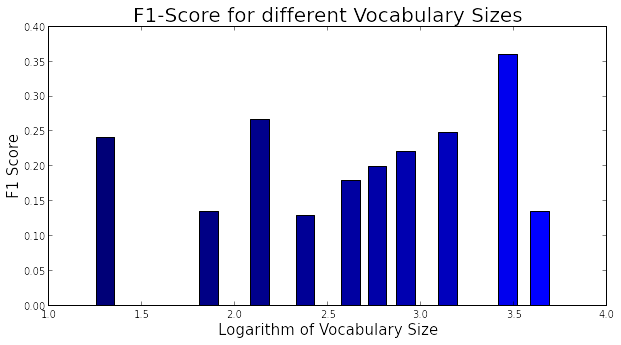

In [18]:
def get_nonzero(coefficients):
    ''' Returns the coeffs that have nonzero coefficients for any of the classes '''
    _nz = map( lambda x: x.nonzero()[0], coefficients )
    non_zero = np.concatenate(_nz)
    return np.unique(non_zero)
    

def P6(C_values):
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

### STUDENT START ###

    ## a) Compare non-zero coeffs
    print_section('a', 'Compare the non-zero coeffs')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)

    logr_l2 = LogisticRegression(penalty='l2', C=.2)
    logr_l2.fit(X, train_labels)
    print '- Non-zero coefs with L2:', len(get_nonzero(logr_l2.coef_))

    logr = LogisticRegression(penalty='l1', C=.2)
    logr.fit(X, train_labels)
    print '- Non-zero coefs with L1:', len(get_nonzero(logr.coef_))
    
    
    ## b) Generate accuracy - vocab size plot figure
    print_section('\nb', 'Accuracy vs Vocabulary Size')
    
    vocab_size = []
    f1_scores = []
    
    for _c in C_values:
        print '- Training with C = {:4} ...'.format(_c),
        # Initialize standard vectorizer
        _vect = CountVectorizer()
        _X = _vect.fit_transform(train_data)
        
        # Train LogReg with L1 and get non-zero coeffs 
        _prelr = LogisticRegression(penalty='l1', C=_c, tol=.01)
        _prelr.fit(_X, train_labels)
        nz_coefs = get_nonzero(_prelr.coef_)
        vocab_size.append( len(nz_coefs) )
        print 'Vocab = {:5}  '.format( len(nz_coefs) ),
        
        # Prune vocabulary and train new LogReg with L2
        _vect.vocabulary_ = { k:v for k,v in _vect.vocabulary_.iteritems() if v in nz_coefs }
        _X_new = _vect.transform(train_data)
        lr = LogisticRegression(penalty='l2', C=_c, tol=.1)
        lr.fit(_X_new[:2034], train_labels[:2034])

        # Get accuracy
        _X_dev = _vect.transform(dev_data)
        _pred = lr.predict(_X_dev)
        _f1 = metrics.f1_score(dev_labels, _pred)
        f1_scores.append( _f1 )
        print 'F1-score = {:.1%}'.format(_f1) 
            
    return vocab_size, f1_scores
        
### STUDENT END ###

C_values = [.01, .03, .05, .1, .2, .3, .5, 1, 10, 20]
vocab, f1_s = P6(C_values)

# Plot figure
max_c = max(C_values)
bar_colors = map( lambda x: (0, 0, np.power( (x*1.) / max_c, .1) ), C_values)
fig, ax = plt.subplots(1, figsize=(10,5))
ax.bar(np.log10(vocab), f1_s, color=bar_colors, width=.1)
ax.set_title('F1-Score for different Vocabulary Sizes', size=20)
ax.set_xlabel('Logarithm of Vocabulary Size', size=15)
ax.set_ylabel('F1 Score', size=15)

plt.show()

** NOTE: the color varies according to the value of C (black being lower Cs and blue higher Cs) **

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [11]:
def P7():
    
### STUDENT START ###

    # TF-IDF Vectorize
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train_data)
    X_dev = vectorizer.transform(dev_data)

    # Train model and get predicted probabilities
    logreg = LogisticRegression(penalty='l2', C=100)
    logreg.fit(X_train, train_labels)
    predicted = logreg.predict(X_dev)
    pred_prob = logreg.predict_proba(X_dev)

    # Report documents with biggest R
    R = [ max(x) / x[dev_labels[i]] for i,x in enumerate(pred_prob) ]
    documents = np.argsort(-np.array(R))[:3]

    for d in documents:
        print '\n Document #{}'.format(d)
        print ' ' + '='*len('Document #{}'.format(d))
        print ' + Predicted topic:', pretty_categories[predicted[d]]
        print ' + Actual topic:',pretty_categories[dev_labels[d]]

        print '\n', dev_data[d], '\n'

## STUDENT END ###

P7()


 Document #215
 + Predicted topic: Graphics
 + Actual topic: Religion

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use of this book. See th

ANSWER:  
For the first two examples (documents \#215 and \#665) the model has predicted computer graphics since there seems to be many words in the document that are usually found in computer graphic texts, such as: `ftp`, `email`, `ASCII`, `LaTeX`, `Apple LaserWriter`, `Microsoft Word` , etc...  
The third document seems to be harder to classify since no topic-specific words seem to appear. However, the absence of these could lead a human analyzer to predict Atheism rather than Religion.  
  
These documents seem to illustrate two main problems in the classifier we have built:  
1. Short documents are harder to predict  
2. Documents may contain features from other categories (in more measure than they might contain words related to the document's topic).  


### Workarounds for short documents

Workarounds for the first problem seem to be of a harder nature, since a possible expansion of the document in part needs some sort of prior classification. A possibility to increment the number of features in short documents could be to **expand non-common words with their dictionary definition**, and include the words in the definition as part of the features as well. However, other problems may come with this workaround, for instance we would like to somehow normalize the number of features each definition adds (if not topics with words with longer definitions may bias shorter documents). Additionally, words frequently have multiple definitions with different meanings (and topics) so choosing one (or multiple) to increment the feature set becomes another challenge to tackle.

  
### Workarounds for documents with different topic-specific words

Workarounds for the second problem seem more in scope with this assignment. The main idea is to come up with a way to break the tie between the counts of words, and boost the weight of "true" topic-specific terms:  

##### **Increase weight for capitalized words**  
A quick scan of the second document seems to suggest that the most important term in the document is "Book of Mormon". Capitalized words (excluding those capitalized by punctuation) could be more indicative of the document's topic. This applies either for words that only appear capitalized (such as names) or words like "book" (although "book" may not be specifically indicative of any topic in particular, "Book" is clearly more likely to refer to sacred scriptures or specific texts more common in religion discussions).  
  
##### **Introduction and conclusion**  
In longer documents, the words at the start or end of the document might be more indicative of the topic of the document. Usually, longer documents tend to summarize the content to be discussed in the first sentences, and might sum up the conclusions in the last sentences. If this is so, the words in these sub-sections will be more indicative of the topic of a document than the words in the rest of the document.

Possible drawbacks, might be drawing the line on the length of this subsections. However, by boosting the weight of words in the 2~3 sentences at the start and end of a document might help improve accuracy for long documents with this problem.  
  
##### **Weights non-linear in word counts**  
The first document seems to be somewhat of a tie between computer-graphic terms and religion. However, there seems to be a clear distinction: religious terms have higher counts (e.g. Book of Mormon) while computer-graphics are not repeated at all.  

From these documents we might infer that when using words from another topic (usually more as medium or tool than of the theme or main idea itself) we are less likely to repeat the same term. Therefore, a document with a single word of topic A repeated 5 times and 5 words from topic B that occur once, might be more likely to be actually of topic A.  

A possible solution for this might be to have non-linear weights on the frequency count. Both vectorizers will give the same weight for two words that occur once, than for a word that occurs twice (in the case of the TF-IDF this holds if the IDF is the same). However, we might want to assign a faster increasing relationship (such as any polynomial or  exponential). In the following section we will implement a simple polynomial relationship: $w = count^p$.  


(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

### Implementing non-linear weights  

We will experiment with the concept of using weights polynomic on the frequency count of the word on a specific document. A possible downside might be overweighting common words, and for that we shall experiment with including the `stop_words = 'english'` option of the Vectorizers.  
  
We shall also consider the regularization method (`'l1` and `'l2'`) and the regularization weight through the parameter `C` (the inverse of the regularization weight).  
  
Additionally, for the TF-IDF vectorizer, we shall experiment as well by disabling the lowercase-ing of the documents (this would be similar to one of the solutions suggested above, however ths proposed approach is more complex since it would only apply to non-punctuation capitalized words only).  

In [24]:
def transform_train_compare(train, dev, powers, c):
    ''' Creates a table that compares (f1score) L1 to L2 models for different p's '''
    print '\x1b[31m   - Using C = {}\x1b[0m'.format(c)
    
    print ' Power   L1 F1-score   L2 F1-score'
    for _p in powers:

        # Calculate elementwise power of train and dev data
        X_p_train = X_train.copy()
        X_p_train.data **= _p
        X_p_dev = X_dev.copy()
        X_p_dev.data **= _p

        # Train models and get f1-scores
        logregL1 = LogisticRegression(penalty='l1', C=c)
        logregL1.fit(X_p_train, train_labels)
        predictedL1 = logregL1.predict(X_p_dev)

        logregL2 = LogisticRegression(penalty='l2', C=c)
        logregL2.fit(X_p_train, train_labels)
        predictedL2 = logregL2.predict(X_p_dev)

        f1L1 = metrics.f1_score(dev_labels, predictedL1)
        f1L2 = metrics.f1_score(dev_labels, predictedL2)
        print ' {:^5}     {:>.2%}        {:>.2%}'.format(_p, f1L1, f1L2)

#### CountVectorizer

In [26]:
# In order to impose non-linear weights we can transform X to be the element-wise power of X
  #  that way, counts of 1 will weight 1, counts of 2 will weight 4, and so on.
    
# Let us experiment with the power *p* and see results
powers = [1, 2, 3, 5, 10]

## 1) Standard Count Vectorizer
print_section('1', 'Vanilla CountVectorizer')
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data)
X_dev = vectorizer.transform(dev_data)
transform_train_compare(X_train, X_dev, powers, c=.2)

## 2) Standard Count Vectorizer + Stop Words
print_section('2', 'CountVectorizer + Stop-words')
vectorizer = CountVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train_data)
X_dev = vectorizer.transform(dev_data)
transform_train_compare(X_train, X_dev, powers, c=.2)



1) Vanilla CountVectorizer
   - Using C = 0.2
 Power   L1 F1-score   L2 F1-score
   1       68.27%        70.59%
   2       59.86%        60.16%
   3       56.06%        45.20%
   5       43.67%        33.51%
  10       33.72%        19.09%

2) CountVectorizer + Stop-words
   - Using C = 0.2
 Power   L1 F1-score   L2 F1-score
   1       70.53%        72.99%
   2       59.84%        68.47%
   3       55.59%        59.23%
   5       45.03%        53.90%
  10       33.98%        51.66%


##### TF-IDF Vectorizer

In [27]:
## 3) TF-IDF Vectorizer
print_section('3', 'Vanilla TF_IDF')
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data)
X_dev = vectorizer.transform(dev_data)
transform_train_compare(X_train, X_dev, powers, c=500)

## 4) TF-IDF Vectorizer + Stop Words
print_section('4', 'TF_IDF + Stop-words')
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(train_data)
X_dev = vectorizer.transform(dev_data)
transform_train_compare(X_train, X_dev, powers, c=500)

## 5) TF-IDF Vectorizer + Capitalized words
print_section('5', 'TF_IDF + Capitalized words')
vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(train_data)
X_dev = vectorizer.transform(dev_data)
transform_train_compare(X_train, X_dev, powers, c=500)

## 6) TF-IDF Vectorizer + Stop Words + Capitalized words
print_section('6', 'TF_IDF + Stop-words + Capitalized words')
vectorizer = TfidfVectorizer(stop_words='english', lowercase=False)
X_train = vectorizer.fit_transform(train_data)
X_dev = vectorizer.transform(dev_data)
transform_train_compare(X_train, X_dev, powers, c=500)



3) Vanilla TF_IDF
   - Using C = 500
 Power   L1 F1-score   L2 F1-score
   1       71.17%        76.48%
   2       73.93%        76.89%
   3       69.76%        67.33%
   5       49.06%        29.43%
  10       15.49%        14.01%

4) TF_IDF + Stop-words
   - Using C = 500
 Power   L1 F1-score   L2 F1-score
   1       72.30%        77.89%
   2       72.27%        74.81%
   3       68.37%        67.44%
   5       51.59%        33.58%
  10       17.02%        14.61%

5) TF_IDF + Capitalized words
   - Using C = 500
 Power   L1 F1-score   L2 F1-score
   1       70.68%        76.06%
   2       72.50%        75.93%
   3       66.46%        64.80%
   5       47.64%        25.63%
  10       14.31%        14.01%

6) TF_IDF + Stop-words + Capitalized words
   - Using C = 500
 Power   L1 F1-score   L2 F1-score
   1       71.55%        77.20%
   2       72.39%        75.13%
   3       65.93%        64.90%
   5       49.40%        29.51%
  10       15.55%        14.31%


### Conclusion   
The first obvious conclusion is that with higher (>2) `p`s the accuracy decreases considerably.  
  
Given the above results it seems that `CountVectorizer` doesn't combine well with the proposed non-linear weights. Additionally, regularization methods, weights and stop-words don't seem to affect this observed result.  
  
The case of the `TF-IDF` is not as clear cut. The proposed non-linearity of weights, for the specific case of $p = 2$, shows minor improvements in accuracy for the case of `l1` regularization. For `l2` even the $p = 2$ shows somewhat lower accuracies, except for the plain vanilla vectorizer (No stop-words, and without preserving capitalized words). `l2` regularization shows overall better accuracies than `l1`.  
  
Of all the vectorizer-model combinations tried, the stop-word + l2 (with linear weights) seems to perform best. However, it remains open if adding the more intricate capitalized words approach would help improve performance (with or without the non-linear weights). 